<img src="https://www.pbiforum.net/mag/wp-content/uploads/2017/11/shutterstock_31312693.jpg">

- This project deals with the prediction of biological response based on molecular data in each column. 

- Drug development depends on the biological response with respect to many factors. Machine learning can help us understand if the drug makes a difference with regard to treatment. 

- Each column represents molecular data.

- Since, they are many feature columns. The challenge would be to reduce the feature space.



- Steps
  - General understanding of the data
  - Dimensionality Reduction through PCA and t-sne
  - Check for covariate shift between training and test set
  - Hyperparameter search through RandomizedSearchCV
  - Feature Importance of the individual column data
  - Implementation of model on test set

## Libraries

In [1]:
import numpy as np 

import pandas as pd 

import os

import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix

import time

from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')


## References

- https://towardsdatascience.com/why-you-are-using-t-sne-wrong-502412aab0c0
- https://www.analyticsvidhya.com/blog/2017/07/covariate-shift-the-hidden-problem-of-real-world-data-science/
- https://datatofish.com/confusion-matrix-python/

## Read Data

In [2]:
data = pd.read_csv("../input/bioresponse/train.csv")
print(data.head(10))

   Activity        D1        D2    D3    D4        D5        D6        D7  \
0         1  0.000000  0.497009  0.10  0.00  0.132956  0.678031  0.273166   
1         1  0.366667  0.606291  0.05  0.00  0.111209  0.803455  0.106105   
2         1  0.033300  0.480124  0.00  0.00  0.209791  0.610350  0.356453   
3         1  0.000000  0.538825  0.00  0.50  0.196344  0.724230  0.235606   
4         0  0.100000  0.517794  0.00  0.00  0.494734  0.781422  0.154361   
5         0  0.133333  0.771035  0.20  0.25  0.122153  0.677398  0.267224   
6         1  0.066700  0.567401  0.10  0.00  0.116578  0.689802  0.274886   
7         1  0.133333  0.610057  0.15  0.00  0.105176  0.759602  0.313393   
8         1  0.000000  0.776816  0.05  0.00  0.458446  0.738631  0.246347   
9         0  0.100000  0.768150  0.10  0.25  0.262299  0.598972  0.377065   

         D8        D9  ...  D1767  D1768  D1769  D1770  D1771  D1772  D1773  \
0  0.585445  0.743663  ...      0      0      0      0      0      0     

- Check for Missing values
- Check name of columns
- Find categorical and numerical columns

In [3]:
print("Missing Values",data.isnull().sum().sum())
print("Column names",data.columns)

Missing Values 0
Column names Index(['Activity', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9',
       ...
       'D1767', 'D1768', 'D1769', 'D1770', 'D1771', 'D1772', 'D1773', 'D1774',
       'D1775', 'D1776'],
      dtype='object', length=1777)


In [4]:
# select the float columns
df_float = data.select_dtypes(include=[np.float])
print("Float Columns",df_float.columns)

# select int columns
df_int = data.select_dtypes(include=[np.int])
print("Int columns",df_int.columns)

# select object columns
df_object = data.select_dtypes(include=[object])
print("object columns",df_object.columns)

Float Columns Index(['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10',
       ...
       'D942', 'D943', 'D944', 'D945', 'D946', 'D947', 'D948', 'D949', 'D950',
       'D951'],
      dtype='object', length=942)
Int columns Index(['Activity', 'D23', 'D27', 'D28', 'D51', 'D72', 'D94', 'D170', 'D568',
       'D858',
       ...
       'D1767', 'D1768', 'D1769', 'D1770', 'D1771', 'D1772', 'D1773', 'D1774',
       'D1775', 'D1776'],
      dtype='object', length=835)
object columns Index([], dtype='object')


- Find Distribution of the labels

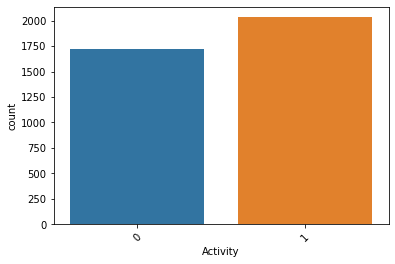

In [5]:
g1 = sns.countplot(x=data["Activity"])
    

g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
plt.show()

- Fair share of distribution for both labels. No need for sampling techniques

## Dimensionality Reduction

- This is a high dimensional data set with too many dimensions. Let's use PCA and t-sne to see if we can extract features

In [6]:
Scaleddata = MinMaxScaler().fit_transform(data)
data = pd.DataFrame(Scaleddata,columns=data.columns)

- Let's look at the cumulative variance with repsect to the number of the components

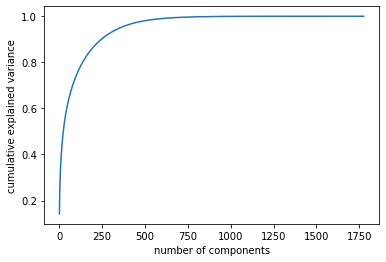

In [7]:
pca = PCA().fit(data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

- We need 500 components to describe 95 - 100 % of the variance

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 3751 samples in 0.267s...
[t-SNE] Computed neighbors for 3751 samples in 20.443s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3751
[t-SNE] Computed conditional probabilities for sample 2000 / 3751
[t-SNE] Computed conditional probabilities for sample 3000 / 3751
[t-SNE] Computed conditional probabilities for sample 3751 / 3751
[t-SNE] Mean sigma: 2.967892
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.993523
[t-SNE] KL divergence after 1000 iterations: 0.820091


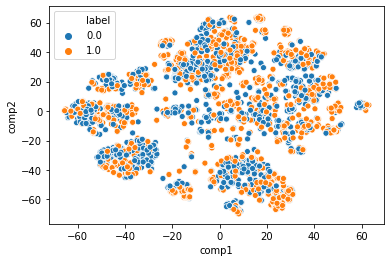

In [8]:
# Reduce dimensionality through PCA

y = data["Activity"]
X = data.drop(columns=['Activity'])

pca = PCA(n_components=750)
X_pca = pca.fit_transform(X) 


# Then reduce further with t-sne
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000, learning_rate=200)
tsne_results = tsne.fit_transform(X_pca[:,:])

df_tsne = pd.DataFrame(tsne_results, columns=['comp1', 'comp2'])
df_tsne['label'] = y[:]
sns.scatterplot(x='comp1', y='comp2', data=df_tsne, hue='label')

- No clear seggregation of classes
- Not a good idea to take PCA and t-sne data for prediction
- We will have to utilize the entire dataset

# Check for covariate shift between training and testing data set

<img src="https://cdn.analyticsvidhya.com/wp-content/uploads/2017/07/07230628/plot1.png">







- In case of drug trials, there could be a difference between the testing environments.
- This could lead to discrepancy while predicting test features, if the test features contain a different data distribution compared to training data
- Below, let's check if the difference actually exists

In [9]:
train = pd.read_csv("../input/bioresponse/train.csv")
test = pd.read_csv("../input/bioresponse/test.csv")


# Label for predicting a strong adherence to the testing sets
train['label'] = 0
test['label'] = 1

training = train.drop('Activity',axis=1) 

# Combine testing and training sets
combine = training.append(test)
y =combine['label']
combine.drop(columns = ['label'],inplace=True)


model = LGBMClassifier(n_estimators = 50)
drop_list = []

for col in combine.columns:
    score = cross_val_score(model,pd.DataFrame(combine[col]),y,cv=2,scoring='roc_auc')
    #print(score)
    if (np.mean(score) > 0.7):
        drop_list.append(col)
        print("Column with covariate shift:", col)

In [10]:
if len(drop_list)==0: 
    print("No presence of covariate shift")

No presence of covariate shift


# Implementation with LightGBM and Hyperparameter search through RandomizedSearchCV

In [11]:
data = pd.read_csv("../input/bioresponse/train.csv")

X = data
X = X.drop(columns='Activity')

y = data['Activity']
y = y.values
y = y.reshape((len(y), 1))

# split into train and test sets
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=32)

columns  = X_train.columns

# Normalizing Column values
for col in columns:
    MinMax = MinMaxScaler()
    
    X_train_arr = X_train[col].astype(float).values
    X_test_arr = X_test[col].astype(float).values   
        
            
    X_train_arr = MinMax.fit_transform(X_train_arr.reshape(-1,1))
    X_test_arr = MinMax.transform(X_test_arr.reshape(-1,1))
            
    X_train[col]  = X_train_arr 
    X_test[col]   = X_test_arr
        


In [12]:
#fit_params={"early_stopping_rounds":100, 
           # "eval_metric" : 'binary_logloss', 
          #"eval_set" : [(X_test,y_test)],
          #'eval_names': ['valid'],
          #'verbose': 100,
          #'categorical_feature': 'auto'}

#param_test ={  'n_estimators': [50,100,200,400, 700, 1000],
  #'colsample_bytree': [0.7, 0.8],
  #'max_depth': [15,20,25],
  #'num_leaves': [50, 100, 200],
  #'reg_alpha': [1.1, 1.2, 1.3],
 #'reg_lambda': [1.1, 1.2, 1.3],
# 'min_split_gain': [0.3, 0.4],
#'subsample': [0.7, 0.8, 0.9],
 # 'subsample_freq': [20]}

In [13]:
#clf = LGBMClassifier(random_state=314, silent=True, metric='None', n_jobs=2)
#model = RandomizedSearchCV(
   #estimator=clf, param_distributions=param_test, 
   # scoring='neg_log_loss',
   # cv=3,
   # refit=True,
  # random_state=314,
  # verbose=True)

In [14]:
#model.fit(X_train, y_train, **fit_params)
#print('Best score reached: {} with params: {} '.format(model.best_score_, model.best_params_))

In [15]:
model = LGBMClassifier(random_state=314, silent=True, n_jobs=2,subsample_freq = 20, subsample = 0.9, 
                       reg_lambda = 1.2, reg_alpha = 1.1,num_leaves= 200, n_estimators = 700, 
                       min_split_gain =  0.4, max_depth =  15, colsample_bytree = 0.8)

In [16]:
model.fit(X_train, y_train)
pred = model.predict_proba(X_test)

print("Log Loss Probability: ",log_loss(y_test,pred))

Log Loss Probability:  0.4416465387847493


- Plot confusion Matrix

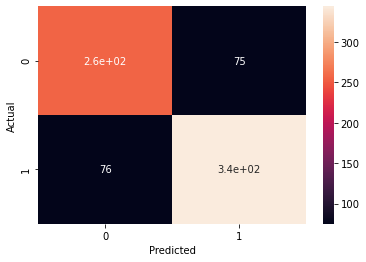

In [17]:
pred = model.predict(X_test)
y_test = y_test.flatten()

#print(np.shape(y_test))

data = {'y_Actual':    y_test,
        'y_Predicted': pred
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

sns.heatmap(confusion_matrix, annot=True)
plt.show()

# Feature Importance

In [18]:
def plotImp(model, X , num = 20):
    
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    plt.figure(figsize=(100, 500))    
    sns.set(font_scale = 5)
    
    #columns = feature_imp.sort_values(by="Value",ascending=False)[0:num]['Feature'].to_list()
    
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Feature imprtances')
    plt.tight_layout()
    
    plt.show()
    
    
plotImp(model, X_train , num =300)


# Implement model on Test Set

In [19]:
X_train = pd.read_csv("../input/bioresponse/train.csv")
X_test =  pd.read_csv("../input/bioresponse/test.csv")

y_train = X_train["Activity"]

X_train.drop(columns=["Activity"],inplace=True)


columns  = X_train.columns

# Normalizing column values
for col in columns:
    MinMax = MinMaxScaler()
    
    X_train_arr = X_train[col].astype(float).values
    X_test_arr = X_test[col].astype(float).values   
        
            
    X_train_arr = MinMax.fit_transform(X_train_arr.reshape(-1,1))
    X_test_arr = MinMax.transform(X_test_arr.reshape(-1,1))
            
    X_train[col]  = X_train_arr 
    X_test[col]   = X_test_arr

In [20]:
model = LGBMClassifier(random_state=314, silent=True, n_jobs=2,subsample_freq = 20, subsample = 0.9, 
                       reg_lambda = 1.2, reg_alpha = 1.1,num_leaves= 200, n_estimators = 700, 
                       min_split_gain =  0.4, max_depth =  15, colsample_bytree = 0.8)

In [21]:
model.fit(X_train,y_train)

LGBMClassifier(colsample_bytree=0.8, max_depth=15, min_split_gain=0.4,
               n_estimators=700, n_jobs=2, num_leaves=200, random_state=314,
               reg_alpha=1.1, reg_lambda=1.2, subsample=0.9, subsample_freq=20)

In [22]:
predicted_prob = model.predict_proba(X_test)

In [23]:
Probability = predicted_prob[:,1]
MoleculeId = np.array(range(1,len(X_test)+1))

In [24]:
submission = pd.DataFrame()
submission["MoleculeId"] = MoleculeId
submission['PredictedProbability'] = Probability

In [25]:
submission.to_csv('submission.csv',index=None)

In [26]:
print(submission)

      MoleculeId  PredictedProbability
0              1              0.891176
1              2              0.985786
2              3              0.513914
3              4              0.984226
4              5              0.037407
...          ...                   ...
2496        2497              0.277293
2497        2498              0.058227
2498        2499              0.967421
2499        2500              0.789723
2500        2501              0.124544

[2501 rows x 2 columns]


- Summary
  - Feature D10, D8, D101,D104 seems to play a major role in prediction
  - However, Feature elimination through feature importance seems to not improve the scores.

Would love to recieve feedback!